In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Load the dataset
input_file = 'data.csv'
output_folder = 'company_datasets'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file
df = pd.read_csv(input_file)

# Clean up the dataset (remove '$' from financial columns and convert to numeric)
financial_columns = ['Close/Last', 'Open', 'High', 'Low']
for col in financial_columns:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Convert the Date column to datetime, handling mixed formats
df['Parsed_Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Fallback parsing attempt
df['Parsed_Date'] = df['Parsed_Date'].fillna(pd.to_datetime(df['Date'], format='%m-%d-%Y', errors='coerce'))

# Identify problematic rows
invalid_dates = df[df['Parsed_Date'].isna()]

if not invalid_dates.empty:
    invalid_file = os.path.join(output_folder, "invalid_dates.csv")
    invalid_dates.to_csv(invalid_file, index=False)
    print(f"Invalid dates found. Please review {invalid_file}")
    raise ValueError("Some dates could not be parsed. Check 'invalid_dates.csv' for details.")

# Use the parsed dates column and drop the original
df['Date'] = df['Parsed_Date']
df.drop(columns=['Parsed_Date'], inplace=True)

# Generate separate datasets for each company
companies = df['Company'].unique()
for company in companies:
    company_data = df[df['Company'] == company]
    output_file = os.path.join(output_folder, f"{company}_data.csv")
    company_data.to_csv(output_file, index=False)
    print(f"Dataset for {company} saved to {output_file}")

Dataset for AAPL saved to company_datasets/AAPL_data.csv
Dataset for SBUX saved to company_datasets/SBUX_data.csv
Dataset for MSFT saved to company_datasets/MSFT_data.csv
Dataset for CSCO saved to company_datasets/CSCO_data.csv
Dataset for QCOM saved to company_datasets/QCOM_data.csv
Dataset for META saved to company_datasets/META_data.csv
Dataset for AMZN saved to company_datasets/AMZN_data.csv
Dataset for TSLA saved to company_datasets/TSLA_data.csv
Dataset for AMD saved to company_datasets/AMD_data.csv
Dataset for NFLX saved to company_datasets/NFLX_data.csv


In [3]:
data = pd.read_csv('company_datasets/AMD_data.csv')
# Reverse the data to ensure earliest -> latest order
data = data.iloc[::-1].reset_index(drop=True)


# Ensure data is sorted by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')

# Calculate derived features
data['EMA-12'] = data['Close/Last'].ewm(span=12, adjust=False).mean()
data['EMA-26'] = data['Close/Last'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA-12'] - data['EMA-26']
#delta = data['Close/Last'].diff()
#gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
#loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
#rs = gain / loss
#data['RSI'] = 100 - (100 / (1 + rs))
data['Returns'] = data['Close/Last'].pct_change()
data['SMA-5'] = data['Close/Last'].rolling(window=5).mean()
data['SMA-20'] = data['Close/Last'].rolling(window=20).mean()
data['Volatility'] = data['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data = data.dropna()
'''
# Normalize features
data['Close/Last'] = data['Close/Last'] / data['Close/Last'].iloc[0]
data['Open'] = data['Open'] / data['Close/Last'].iloc[0]
data['High'] = data['High'] / data['Close/Last'].iloc[0]
data['Low'] = data['Low'] / data['Close/Last'].iloc[0]
data['Volume'] = data['Volume'] / data['Volume'].max()
data['Returns'] = data['Returns'] / data['Returns'].max()
data['Volatility'] = data['Volatility'] / data['Volatility'].max()
data['MACD'] = data['MACD'] / data['MACD'].max()
data['RSI'] = data['RSI'] / 100  # RSI is already bounded between 0 and 100
sma_mean = data[['SMA-5', 'SMA-20']].mean().mean()
sma_std = data[['SMA-5', 'SMA-20']].std().std()
data['SMA-5'] = (data['SMA-5'] - sma_mean) / sma_std
data['SMA-20'] = (data['SMA-20'] - sma_mean) / sma_std
'''

# Remove unnecessary columns like 'Date' and 'Name'
data = data.drop(columns=['Date', 'Name'], errors='ignore')

In [4]:
print(data.head(5))

   Company  Close/Last    Volume  Open  High   Low    EMA-12    EMA-26  \
19     AMD        3.82  32032580  3.68  3.83  3.65  3.772216  3.952710   
20     AMD        3.69  28169780  3.76  3.84  3.65  3.759568  3.933250   
21     AMD        3.66  11606420  3.69  3.71  3.65  3.744250  3.913010   
22     AMD        3.60  14351430  3.67  3.68  3.59  3.722057  3.889824   
23     AMD        3.63  16627450  3.62  3.69  3.59  3.707895  3.870578   

        MACD   Returns  SMA-5  SMA-20  Volatility  
19 -0.180494  0.035230  3.704  3.8040    0.018715  
20 -0.173683 -0.034031  3.700  3.7565    0.026352  
21 -0.168760 -0.008130  3.702  3.7380    0.025408  
22 -0.167766 -0.016393  3.692  3.7230    0.026569  
23 -0.162683  0.008333  3.680  3.7215    0.026261  


In [74]:
def reward_function(action, current_price):
    global cash, stocks_held, transaction_fee
    
    if action == 0: # Buy
        if cash >= (current_price + transaction_fee):  # Ensure enough cash to buy at least one stock
            num_stocks = (cash - transaction_fee) / current_price  # Max stocks we can buy
            total_cost = num_stocks * current_price + transaction_fee  # Total cost
            stocks_held += num_stocks
            cash -= total_cost  # Deduct cash
            return 0  # No immediate reward for buying
        else:
            return -10  # Penalty for invalid buy action (insufficient cash)
    
    elif action == 1:  # Sell
        if stocks_held > 0:  # Ensure stocks are held
            total_value = stocks_held * current_price  # Value of all stocks sold
            profit = total_value - transaction_fee  # Net profit
            cash += total_value - transaction_fee  # Update cash
            stocks_held = 0  # Reset stock holdings
            return profit  # Reward is profit/loss
        else:
            return -10  # Penalty for invalid sell action (no stocks to sell)
    
    elif action == 2:  # Hold
        return 0  # No reward for holding (neutral behavior)
    
    return 0  # Default reward

def update_state(time_step, data, cash, stocks_held ):
    """Update the state vector with market data and raw agent-specific features."""
    # Extract market features for the current time step
    market_features = data.iloc[time_step][[
        'Close/Last', 'Open', 'High', 'Low', 'Volume',
        'Returns', 'SMA-5', 'SMA-20', 'Volatility', 'MACD'
    ]].values.tolist()

    # Use raw agent-specific features
    agent_features = [cash, stocks_held]  # Directly append raw cash and stocks_held values

    # Combine market and agent features into a single state
    state = market_features + agent_features
    return state

def select_action ( state_idx, exploration_rate ):
    if np.random.rand() < exploration_rate:
        # Explore: Randomly select an action index buy (0), sell (1), or hold (2)
        return int(np.random.choice([0, 1, 2]))
    else:
        return int(np.argmax(Q[state_idx]))

In [78]:
# Initialize cash and stocks_held for state creation
cash_initial = 1000  # Initial cash
stocks_held_initial = 0  # No stocks held initially

# Create the initial states array
states = []
for t in range(len(data)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Initialize Q-table
Q = np.zeros((len(states), len(actions)))

# Training Parameters
learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 0.15
num_episodes = 2500

# State Parameters
transaction_fee = 0  # Fee for any transaction

# Performance Metrics
total_profits = []

# Training Loop
for episode in range(num_episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data, cash, stocks_held)
    state_idx = 0  # Initial state index

    for t in range(len(data) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price  # Final net worth
    profit = net_worth - cash_initial  # Subtract initial cash

    total_profits.append(profit)
    print(f"Episode {episode + 1}/{num_episodes}: Profit = {profit}")

# After training, print summary statistics
print(f"Average Profit: {sum(total_profits) / len(total_profits)}")
print(f"Max Profit: {max(total_profits)}")
print(f"Min Profit: {min(total_profits)}")


Episode 1/2500: Profit = 40362.20521090618
Episode 2/2500: Profit = 492.5508657075254
Episode 3/2500: Profit = 1331.313165625434
Episode 4/2500: Profit = 3250.273725714047
Episode 5/2500: Profit = 668.6375161793853
Episode 6/2500: Profit = 2496.0673406835085
Episode 7/2500: Profit = 3113.280606372313
Episode 8/2500: Profit = 709.1481804091673
Episode 9/2500: Profit = 970.5743151205511
Episode 10/2500: Profit = 1418.5652300701568
Episode 11/2500: Profit = 303.37278642579054
Episode 12/2500: Profit = -141.22925204720696
Episode 13/2500: Profit = 1176.4319107744818
Episode 14/2500: Profit = 1733.8871291097976
Episode 15/2500: Profit = 2463.2066998134433
Episode 16/2500: Profit = 894.9387356123484
Episode 17/2500: Profit = 2557.2523754650456
Episode 18/2500: Profit = 9698.12968464247
Episode 19/2500: Profit = 1918.4817723299698
Episode 20/2500: Profit = 4789.885284469068
Episode 21/2500: Profit = 9451.686988176838
Episode 22/2500: Profit = 1449.1908324421129
Episode 23/2500: Profit = 1294.

In [79]:
print (Q)

[[ 2.21893868e+03  1.88544511e+03  1.93717136e+03]
 [ 1.82064577e+03  2.35008361e+03  1.81846602e+03]
 [ 1.66914818e+03  1.67272027e+03  1.68292321e+03]
 ...
 [ 7.27193335e+02  7.58191108e+03  8.81660147e+02]
 [-1.06072169e+00  1.68151394e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


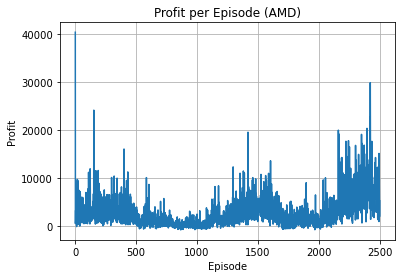

In [87]:
plt.plot(total_profits)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (AMD)')
plt.grid()
plt.show()

In [92]:
Q_AMD = Q
np.save('Q_AMD.npy', Q_AMD)

In [ ]:
data1 = pd.read_csv('company_datasets/AMZN_data.csv')

# Reverse the data to ensure earliest -> latest order
data1 = data1.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data1['EMA-12'] = data1['Close/Last'].ewm(span=12, adjust=False).mean()
data1['EMA-26'] = data1['Close/Last'].ewm(span=26, adjust=False).mean()
data1['MACD'] = data1['EMA-12'] - data1['EMA-26']
data1['Returns'] = data1['Close/Last'].pct_change()
data1['SMA-5'] = data1['Close/Last'].rolling(window=5).mean()
data1['SMA-20'] = data1['Close/Last'].rolling(window=20).mean()
data1['Volatility'] = data1['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data1 = data1.dropna()

Q_AMZN = np.load('Q_AMD.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000  # Initial cash
stocks_held_initial = 0  # No stocks held initially
exploration_rate = 0.10  # Low exploration rate
transaction_fee = 0  # No transaction fee
episodes = 1000  # Number of episodes

# Create the initial states array
states = []
for t in range(len(data1)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data1, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for AMZN
# Performance Metrics
total_profits = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data1, cash, stocks_held)
    state_idx = 0  # Initial state index

    for t in range(len(data1) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data1.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data1, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data1.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price  # Final net worth
    profit = net_worth - cash_initial  # Subtract initial cash

    total_profits.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

# After training, print summary statistics
print(f"Average Profit: {sum(total_profits) / len(total_profits)}")
print(f"Max Profit: {max(total_profits)}")
print(f"Min Profit: {min(total_profits)}")

Episode 1/1000: Profit = 601.242699386434
Episode 11/1000: Profit = 5038.818360990163
Episode 21/1000: Profit = 558.5072786351511
Episode 31/1000: Profit = 1014.31431094962
Episode 41/1000: Profit = 389.2501482666826
Episode 51/1000: Profit = 2193.2378386345035
Episode 61/1000: Profit = 2466.9242699446627
Episode 71/1000: Profit = 1047.6568461464344
Episode 81/1000: Profit = 1812.5443027808801
Episode 91/1000: Profit = 1837.7488637701113
Episode 101/1000: Profit = 530.6761241931642
Episode 111/1000: Profit = 3359.1827037362855
Episode 121/1000: Profit = 1169.7532951075236
Episode 131/1000: Profit = 869.9649750553083
Episode 141/1000: Profit = 96.46139003954613
Episode 151/1000: Profit = 1477.2181140852545
Episode 161/1000: Profit = 1243.9523335210642
Episode 171/1000: Profit = 1679.071580904245
Episode 181/1000: Profit = 839.3966752236229
Episode 191/1000: Profit = 331.63232312742775
Episode 201/1000: Profit = 908.1629295623281
Episode 211/1000: Profit = 91.55903536328219
Episode 221/1

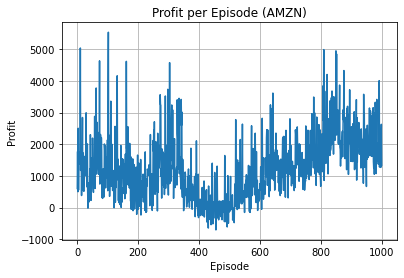

In [104]:
np.save('Q_AMZN.npy', Q_AMZN)

plt.plot(total_profits)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (AMZN)')
plt.grid()
plt.show()

In [106]:
data2 = pd.read_csv('company_datasets/CSCO_data.csv')

# Reverse the data to ensure earliest -> latest order
data2 = data2.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data2['EMA-12'] = data2['Close/Last'].ewm(span=12, adjust=False).mean()
data2['EMA-26'] = data2['Close/Last'].ewm(span=26, adjust=False).mean()
data2['MACD'] = data2['EMA-12'] - data2['EMA-26']
data2['Returns'] = data2['Close/Last'].pct_change()
data2['SMA-5'] = data2['Close/Last'].rolling(window=5).mean()
data2['SMA-20'] = data2['Close/Last'].rolling(window=20).mean()
data2['Volatility'] = data2['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data2 = data2.dropna()

Q_CSCO = np.load('Q_AMZN.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000  # Initial cash
stocks_held_initial = 0  # No stocks held initially
exploration_rate = 0.10  # Low exploration rate 
transaction_fee = 0  # No transaction fee
episodes = 1000  # Number of episodes

# Create the initial states array
states = []
for t in range(len(data2)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data2, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for CSCO
# Performance Metrics
total_profits2 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data2, cash, stocks_held)
    state_idx = 0  # Initial state index

    for t in range(len(data2) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data2.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data2, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data2.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price  # Final net worth
    profit = net_worth - cash_initial  # Subtract initial cash

    total_profits2.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

# After training, print summary statistics
print(f"Average Profit: {sum(total_profits2) / len(total_profits2)}")
print(f"Max Profit: {max(total_profits2)}")
print(f"Min Profit: {min(total_profits2)}")

Average Profit: 1117.2374194533104
Max Profit: 3689.655916831616
Min Profit: -446.2512150125631


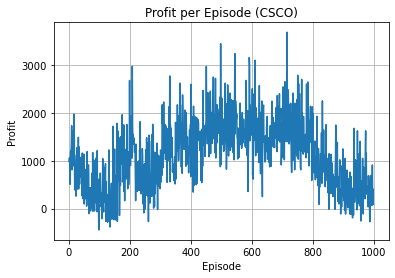

In [107]:
np.save('Q_CSCO.npy', Q_CSCO)

plt.plot(total_profits2)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (CSCO)')
plt.grid()
plt.show()

In [108]:
data3 = pd.read_csv('company_datasets/META_data.csv')

# Reverse the data to ensure earliest -> latest order
data3 = data3.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data3['EMA-12'] = data3['Close/Last'].ewm(span=12, adjust=False).mean()
data3['EMA-26'] = data3['Close/Last'].ewm(span=26, adjust=False).mean()
data3['MACD'] = data3['EMA-12'] - data3['EMA-26']
data3['Returns'] = data3['Close/Last'].pct_change()
data3['SMA-5'] = data3['Close/Last'].rolling(window=5).mean()
data3['SMA-20'] = data3['Close/Last'].rolling(window=20).mean()
data3['Volatility'] = data3['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data3 = data3.dropna()

Q_META = np.load('Q_CSCO.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000  # Initial cash
stocks_held_initial = 0  # No stocks held initially
exploration_rate = 0.10  # Low exploration rate
transaction_fee = 0  # No transaction fee
episodes = 1000  # Number of episodes

# Create the initial states array
states = []
for t in range(len(data3)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data3, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for META
# Performance Metrics
total_profits3 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data3, cash, stocks_held)
    state_idx = 0  # Initial state index

    for t in range(len(data3) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data3.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data3, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data3.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price  # Final net worth
    profit = net_worth - cash_initial  # Subtract initial cash

    total_profits3.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

# After training, print summary statistics
print(f"Average Profit: {sum(total_profits3) / len(total_profits3)}")
print(f"Max Profit: {max(total_profits3)}")
print(f"Min Profit: {min(total_profits3)}")

Average Profit: 1716.3186855510794
Max Profit: 6837.269213298181
Min Profit: -454.83847964518475


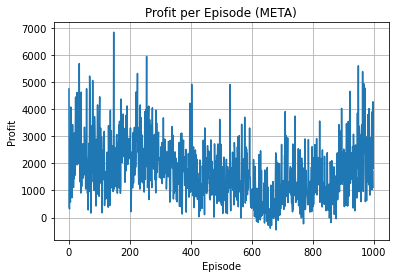

In [109]:
np.save('Q_META.npy', Q_META)

plt.plot(total_profits3)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (META)')
plt.grid()
plt.show()

In [111]:
data4 = pd.read_csv('company_datasets/MSFT_data.csv')

# Reverse the data to ensure earliest -> latest order
data4 = data4.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data4['EMA-12'] = data4['Close/Last'].ewm(span=12, adjust=False).mean()
data4['EMA-26'] = data4['Close/Last'].ewm(span=26, adjust=False).mean()
data4['MACD'] = data4['EMA-12'] - data1['EMA-26']
data4['Returns'] = data4['Close/Last'].pct_change()
data4['SMA-5'] = data4['Close/Last'].rolling(window=5).mean()
data4['SMA-20'] = data4['Close/Last'].rolling(window=20).mean()
data4['Volatility'] = data4['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data4 = data4.dropna()

Q_MSFT = np.load('Q_META.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000  # Initial cash
stocks_held_initial = 0  # No stocks held initially
exploration_rate = 0.10  # Low exploration rate
transaction_fee = 0  # No transaction fee
episodes = 1000  # Number of episodes

# Create the initial states array
states = []
for t in range(len(data4)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data4, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for MSFF
# Performance Metrics
total_profits4 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data4, cash, stocks_held)
    state_idx = 0  # Initial state index

    for t in range(len(data1) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data4.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data4, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data4.iloc[-1]['Close/Last']

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_initial

    total_profits4.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

print(f"Average Profit: {sum(total_profits) / len(total_profits)}")
print(f"Max Profit: {max(total_profits)}")
print(f"Min Profit: {min(total_profits)}")

Average Profit: 1269.4791641410884
Max Profit: 5537.319414278567
Min Profit: -707.7613769914926


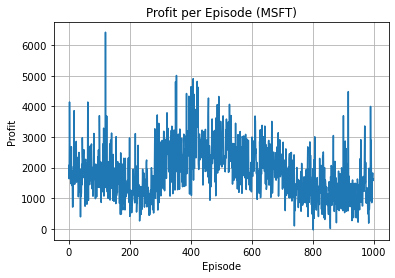

In [112]:
np.save('Q_MSFT.npy', Q_MSFT)

plt.plot(total_profits4)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (MSFT)')
plt.grid()
plt.show()

In [113]:
data5 = pd.read_csv('company_datasets/NFLX_data.csv')

# Reverse the data to ensure earliest -> latest order
data5 = data5.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data5['EMA-12'] = data5['Close/Last'].ewm(span=12, adjust=False).mean()
data5['EMA-26'] = data5['Close/Last'].ewm(span=26, adjust=False).mean()
data5['MACD'] = data5['EMA-12'] - data5['EMA-26']
data5['Returns'] = data5['Close/Last'].pct_change()
data5['SMA-5'] = data5['Close/Last'].rolling(window=5).mean()
data5['SMA-20'] = data5['Close/Last'].rolling(window=20).mean()
data5['Volatility'] = data5['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data5 = data5.dropna()

Q_NFLX = np.load('Q_MSFT.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000
stocks_held_initial = 0
exploration_rate = 0.15
transaction_fee = 0
episodes = 1000

# Create the initial states array
states = []
for t in range(len(data5)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data5, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for NFLX
# Performance Metrics
total_profits5 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data5, cash, stocks_held)
    state_idx = 0

    for t in range(len(data5) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data5.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data5, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data5.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price  # Final net worth
    profit = net_worth - cash_initial  # Subtract initial cash

    total_profits5.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

print(f"Average Profit: {sum(total_profits5) / len(total_profits5)}")
print(f"Max Profit: {max(total_profits5)}")
print(f"Min Profit: {min(total_profits5)}")

Average Profit: 2211.185157302053
Max Profit: 11625.40102145147
Min Profit: -677.5121143986003


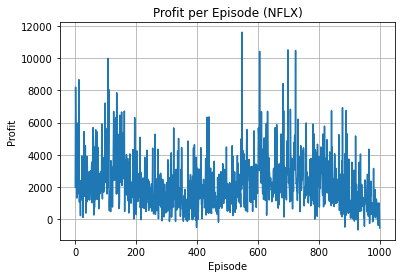

In [114]:
np.save('Q_NFLX.npy', Q_NFLX)

plt.plot(total_profits5)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (NFLX)')
plt.grid()
plt.show()

In [115]:
data6 = pd.read_csv('company_datasets/QCOM_data.csv')

# Reverse the data to ensure earliest -> latest order
data6 = data6.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data6['EMA-12'] = data6['Close/Last'].ewm(span=12, adjust=False).mean()
data6['EMA-26'] = data6['Close/Last'].ewm(span=26, adjust=False).mean()
data6['MACD'] = data6['EMA-12'] - data6['EMA-26']
data6['Returns'] = data6['Close/Last'].pct_change()
data6['SMA-5'] = data6['Close/Last'].rolling(window=5).mean()
data6['SMA-20'] = data6['Close/Last'].rolling(window=20).mean()
data6['Volatility'] = data6['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data6 = data6.dropna()

Q_QCOM = np.load('Q_NFLX.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000
stocks_held_initial = 0
exploration_rate = 0.15
transaction_fee = 0
episodes = 1000

# Create the initial states array
states = []
for t in range(len(data6)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data6, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for QCOM
# Performance Metrics
total_profits6 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data6, cash, stocks_held)
    state_idx = 0

    for t in range(len(data6) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data6.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data6, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data6.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_initial

    total_profits6.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

print(f"Average Profit: {sum(total_profits6) / len(total_profits6)}")
print(f"Max Profit: {max(total_profits6)}")
print(f"Min Profit: {min(total_profits6)}")

Average Profit: 590.5061077673607
Max Profit: 4578.423686585273
Min Profit: -717.1115049330288


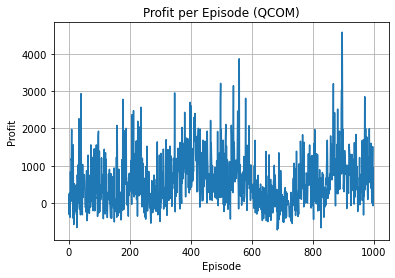

In [116]:
np.save('Q_QCOM.npy', Q_QCOM)

plt.plot(total_profits6)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (QCOM)')
plt.grid()
plt.show()

In [117]:
data7 = pd.read_csv('company_datasets/SBUX_data.csv')

# Reverse the data to ensure earliest -> latest order
data7 = data7.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data7['EMA-12'] = data7['Close/Last'].ewm(span=12, adjust=False).mean()
data7['EMA-26'] = data7['Close/Last'].ewm(span=26, adjust=False).mean()
data7['MACD'] = data7['EMA-12'] - data7['EMA-26']
data7['Returns'] = data7['Close/Last'].pct_change()
data7['SMA-5'] = data7['Close/Last'].rolling(window=5).mean()
data7['SMA-20'] = data7['Close/Last'].rolling(window=20).mean()
data7['Volatility'] = data7['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data7 = data7.dropna()

Q_SBUX = np.load('Q_QCOM.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000
stocks_held_initial = 0
exploration_rate = 0.15
transaction_fee = 0
episodes = 1000

# Create the initial states array
states = []
for t in range(len(data7)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data7, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for SBUX
# Performance Metrics
total_profits7 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data7, cash, stocks_held)
    state_idx = 0

    for t in range(len(data7) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data7.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data7, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data7.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_initial

    total_profits7.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

print(f"Average Profit: {sum(total_profits7) / len(total_profits7)}")
print(f"Max Profit: {max(total_profits7)}")
print(f"Min Profit: {min(total_profits7)}")

Average Profit: 578.2993293379378
Max Profit: 3430.5062515872014
Min Profit: -589.8073228095197


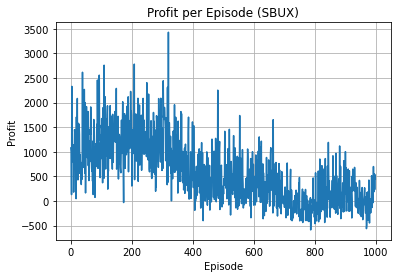

In [118]:
np.save('Q_SBUX.npy', Q_SBUX)

plt.plot(total_profits7)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (SBUX)')
plt.grid()
plt.show()

In [121]:
data8 = pd.read_csv('company_datasets/TSLA_data.csv')

# Reverse the data to ensure earliest -> latest order
data8 = data8.iloc[::-1].reset_index(drop=True)

# Calculate derived features
data8['EMA-12'] = data8['Close/Last'].ewm(span=12, adjust=False).mean()
data8['EMA-26'] = data8['Close/Last'].ewm(span=26, adjust=False).mean()
data8['MACD'] = data8['EMA-12'] - data8['EMA-26']
data8['Returns'] = data8['Close/Last'].pct_change()
data8['SMA-5'] = data8['Close/Last'].rolling(window=5).mean()
data8['SMA-20'] = data8['Close/Last'].rolling(window=20).mean()
data8['Volatility'] = data8['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
data8 = data8.dropna()

Q_TSLA = np.load('Q_SBUX.npy')

# Initialize cash and stocks_held for state creation
cash_initial = 1000
stocks_held_initial = 0
exploration_rate = 0.10
transaction_fee = 0
episodes = 1500

# Create the initial states array
states = []
for t in range(len(data8)):
    # Use the initial cash and stocks_held values
    state = update_state(t, data8, cash_initial, stocks_held_initial)
    states.append(state)

# Convert the list of states to a NumPy array for Q-table indexing
states = np.array(states)

# Define action space
actions = ["buy", "sell", "hold"]

# Train the Q-learning agent for TSLA
# Performance Metrics
total_profits8 = []

# Training Loop
for episode in range(episodes):
    # Reset the environment for the new episode
    cash = cash_initial  # Initial cash
    stocks_held = stocks_held_initial  # No stocks held at the start
    state = update_state(0, data8, cash, stocks_held)
    state_idx = 0

    for t in range(len(data8) - 1):
        # Select an action (returns an index: 0: buy, 1: sell, or 2: hold)
        action = select_action(state_idx, exploration_rate)

        # Perform the selected action and observe the reward
        reward = reward_function(action, data8.iloc[t]['Close/Last'])

        # Update the state for the next time step
        next_state = update_state(t + 1, data8, cash, stocks_held)
        next_state_idx = t + 1

        # Update the Q-table using the Q-learning iteration
        Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state_idx]))

        # Move to the next state
        state = next_state
        state_idx = next_state_idx

    # At the end of the episode, calculate profit
    final_price = data8.iloc[-1]['Close/Last']  # Stock price at the last time step

    # Calculate final net worth and profit
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_initial

    total_profits8.append(profit)
    if episode + 1 % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}: Profit = {profit}")

print(f"Average Profit: {sum(total_profits8) / len(total_profits8)}")
print(f"Max Profit: {max(total_profits8)}")
print(f"Min Profit: {min(total_profits8)}")

Average Profit: 3324.779108455156
Max Profit: 19328.029378379597
Min Profit: -682.8189616995405


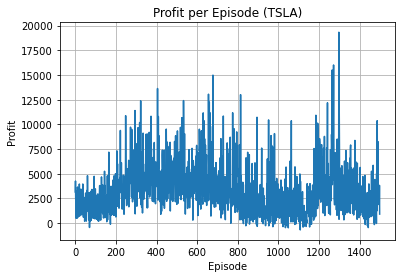

In [122]:
np.save('Q_TSLA.npy', Q_TSLA)

plt.plot(total_profits8)
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Profit per Episode (TSLA)')
plt.grid()
plt.show()

In [ ]:
test_data = pd.read_csv('company_datasets/AAPL_data.csv')

# Reverse the data to ensure earliest -> latest order
test_data = test_data.iloc[::-1].reset_index(drop=True)

# Calculate derived features
test_data['EMA-12'] = test_data['Close/Last'].ewm(span=12, adjust=False).mean()
test_data['EMA-26'] = test_data['Close/Last'].ewm(span=26, adjust=False).mean()
test_data['MACD'] = test_data['EMA-12'] - test_data['EMA-26']
test_data['Returns'] = test_data['Close/Last'].pct_change()
test_data['SMA-5'] = test_data['Close/Last'].rolling(window=5).mean()
test_data['SMA-20'] = test_data['Close/Last'].rolling(window=20).mean()
test_data['Volatility'] = test_data['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
test_data = test_data.dropna()

# Pretrained Q-table
trained_Q = np.load('Q_TSLA.npy')

# Initialize parameters
cash_initial = 1000
stocks_held_initial = 0
exploration_rate = 0.10
test_episodes = 500  # Number of test episodes
actions = ["buy", "sell", "hold"]  # Action space ( for reference and visualization as action space is instead numerical representation )
test_total_profits = []  # Store profits for each test episode

# Testing Loop
for episode in range(test_episodes):
    # Use the trained Q-table for testing
    Q = trained_Q.copy()

    # Reset environment for the episode
    cash = cash_initial
    stocks_held = stocks_held_initial
    state = update_state(0, test_data, cash, stocks_held)
    state_idx = 0

    for t in range(len(test_data) - 1):
        # Select an action with exploration-exploitation trade-off
        if np.random.rand() < exploration_rate:
            action = np.random.choice(range(len(actions)))  # Explore
        else:
            action = np.argmax(Q[state_idx])  # Exploit

        # Perform the selected action and observe the reward
        reward = reward_function(action, test_data.iloc[t]['Close/Last'])

        # Update state for the next time step
        next_state = update_state(t + 1, test_data, cash, stocks_held)
        next_state_idx = t + 1

        # Move to the next state (no updates to Q during testing)
        state = next_state
        state_idx = next_state_idx

    # Calculate profit for this test episode
    final_price = test_data.iloc[-1]['Close/Last']
    net_worth = cash + stocks_held * final_price
    profit = net_worth - cash_initial
    test_total_profits.append(profit)

    # Reset Q-table for the next episode
    Q = np.zeros_like(Q)

    # Print progress every 10 test episodes
    if (episode + 1) % 10 == 0:
        print(f"Test Episode {episode + 1}/{test_episodes}: Profit = {profit}")

# Evaluate Overall Performance
average_profit = sum(test_total_profits) / len(test_total_profits)
max_profit = max(test_total_profits)
min_profit = min(test_total_profits)

print(f"Real-World Performance Over {test_episodes} Test Episodes:")
print(f"Average Profit: {average_profit}")
print(f"Max Profit: {max_profit}")
print(f"Min Profit: {min_profit}")

Test Episode 10/500: Profit = 1258.6814126426557
Test Episode 20/500: Profit = 390.60332240883145
Test Episode 30/500: Profit = 1151.0165686075638
Test Episode 40/500: Profit = 549.4428001664883
Test Episode 50/500: Profit = 847.6966231600193
Test Episode 60/500: Profit = 517.8998344917234
Test Episode 70/500: Profit = 1041.5247920611805
Test Episode 80/500: Profit = 786.1998326255934
Test Episode 90/500: Profit = 1345.0280775197252
Test Episode 100/500: Profit = 893.9126379711138
Test Episode 110/500: Profit = 756.5554603737173
Test Episode 120/500: Profit = 1569.5597896212284
Test Episode 130/500: Profit = 893.7325462245717
Test Episode 140/500: Profit = 1087.4649508819443
Test Episode 150/500: Profit = 1325.280982714297
Test Episode 160/500: Profit = 1063.6837430579953
Test Episode 170/500: Profit = 1905.4447866486885
Test Episode 180/500: Profit = 1420.8060908881853
Test Episode 190/500: Profit = 1373.4753668959943
Test Episode 200/500: Profit = 1204.397361931548
Test Episode 210/5

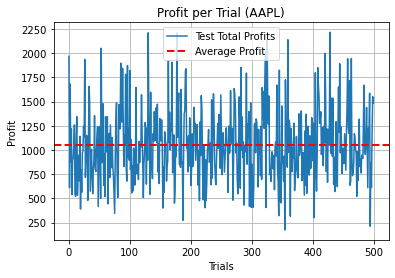

In [138]:
plt.plot(test_total_profits, label='Test Total Profits')
plt.axhline(y=average_profit, color='red', linestyle='dashed', linewidth=2, label='Average Profit')
plt.xlabel('Trials')
plt.ylabel('Profit')
plt.title('Profit per Trial (AAPL)')
plt.legend()
plt.grid()
plt.show()

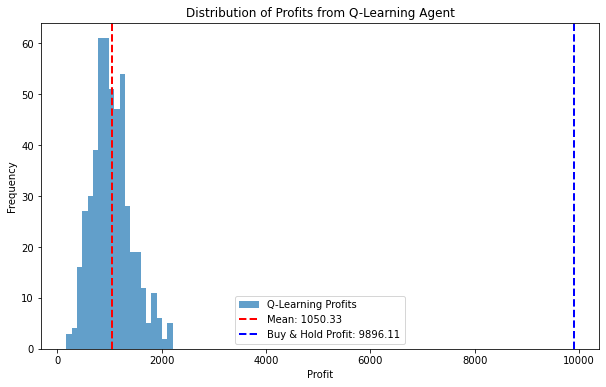

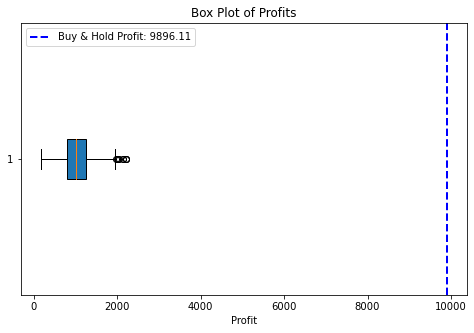

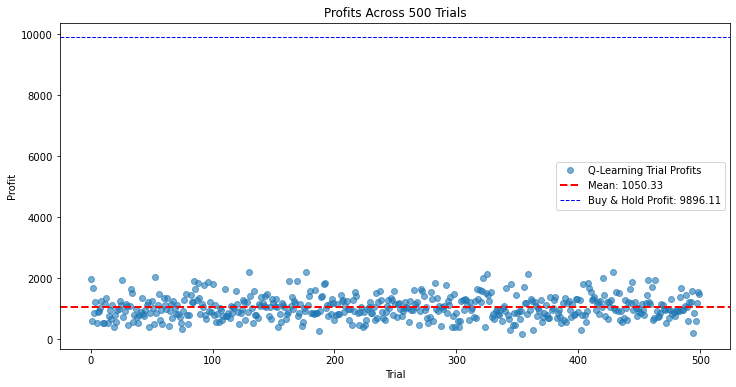

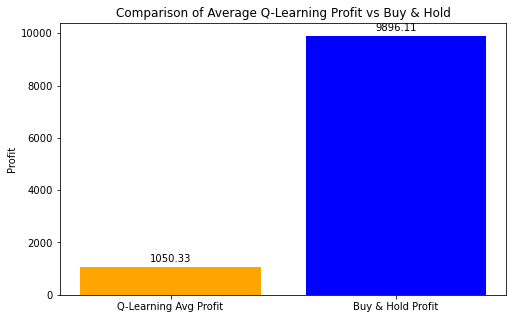

In [140]:
test_profit = test_total_profits.copy()
mean = np.mean(test_profit)
variance = np.var(test_profit)
std = np.std(test_profit)

# This is for calculating the whether simply investing all your money from the start would have been better than using the Q-learning model
scaling_factor = test_data.iloc[-1]['Close/Last'] / test_data.iloc[0]['Close/Last']
initial_investment = cash_initial
final_investment = initial_investment * scaling_factor
buy_hold_profit = final_investment - initial_investment

# 1. Histogram of Profits
plt.figure(figsize=(10, 6))
plt.hist(test_profit, bins=20, alpha=0.7, label='Q-Learning Profits')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(buy_hold_profit, color='blue', linestyle='dashed', linewidth=2, label=f'Buy & Hold Profit: {buy_hold_profit:.2f}')
plt.title('Distribution of Profits from Q-Learning Agent')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. Box Plot of Profits
plt.figure(figsize=(8, 5))
plt.boxplot(test_profit, vert=False, patch_artist=True)
plt.axvline(buy_hold_profit, color='blue', linestyle='dashed', linewidth=2, label=f'Buy & Hold Profit: {buy_hold_profit:.2f}')
plt.title('Box Plot of Profits')
plt.xlabel('Profit')
plt.legend()
plt.show()

# 3. Line Plot of Individual Trial Profits
plt.figure(figsize=(12, 6))
plt.plot(test_profit, marker='o', linestyle='', alpha=0.6, label='Q-Learning Trial Profits')
plt.axhline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axhline(buy_hold_profit, color='blue', linestyle='dashed', linewidth=1, label=f'Buy & Hold Profit: {buy_hold_profit:.2f}')
plt.title('Profits Across 500 Trials')
plt.xlabel('Trial')
plt.ylabel('Profit')
plt.legend()
plt.show()

# 4. Comparison Bar Chart
profits = [mean, buy_hold_profit]
labels = ['Q-Learning Avg Profit', 'Buy & Hold Profit']

plt.figure(figsize=(8, 5))
plt.bar(labels, profits, color=['orange', 'blue'])
plt.title('Comparison of Average Q-Learning Profit vs Buy & Hold')
plt.ylabel('Profit')
for i, v in enumerate(profits):
    plt.text(i, v + (0.02 * max(profits)), f'{v:.2f}', ha='center')
plt.show()

In [141]:
print (f"Average profit: ${mean}")
print (f"Variance: {variance}")
print (f"Standard Deviation: {std}")
print (f"Buy and Hold Profit: ${buy_hold_profit}")

Average profit: $1050.3320912125473
Variance: 139709.35612743377
Standard Deviation: 373.7771476795147
Buy and Hold Profit: $9896.110898919322


In [5]:
test_data = pd.read_csv('company_datasets/AAPL_data.csv')

# Reverse the data to ensure earliest -> latest order
test_data = test_data.iloc[::-1].reset_index(drop=True)

# Calculate derived features
test_data['EMA-12'] = test_data['Close/Last'].ewm(span=12, adjust=False).mean()
test_data['EMA-26'] = test_data['Close/Last'].ewm(span=26, adjust=False).mean()
test_data['MACD'] = test_data['EMA-12'] - test_data['EMA-26']
test_data['Returns'] = test_data['Close/Last'].pct_change()
test_data['SMA-5'] = test_data['Close/Last'].rolling(window=5).mean()
test_data['SMA-20'] = test_data['Close/Last'].rolling(window=20).mean()
test_data['Volatility'] = test_data['Returns'].rolling(window=5).std()

# Drop rows with NaN values from rolling calculations
test_data = test_data.dropna()

print(test_data.head(5))

   Company        Date  Close/Last     Volume     Open     High      Low  \
19    AAPL  2013-08-14     17.8036  753707619  17.7814  18.0089  17.6214   
20    AAPL  2013-08-15     17.7825  489547324  17.7293  17.9428  17.4673   
21    AAPL  2013-08-16     17.9404  361257815  17.8625  17.9622  17.8164   
22    AAPL  2013-08-19     18.1336  509606516  18.0122  18.3479  18.0000   
23    AAPL  2013-08-20     17.8954  358034457  18.2039  18.2347  17.8864   

       EMA-12     EMA-26      MACD   Returns     SMA-5     SMA-20  Volatility  
19  16.696361  16.245043  0.451319  0.018245  16.93492  16.188275    0.025756  
20  16.863460  16.358928  0.504531 -0.001185  17.19850  16.306405    0.024295  
21  17.029143  16.476075  0.553068  0.008880  17.54050  16.444585    0.018728  
22  17.199059  16.598854  0.600205  0.010769  17.82894  16.589995    0.018496  
23  17.306189  16.694895  0.611294 -0.013136  17.91110  16.736570    0.012150  
